# Simulation of Renewable-Powered Edge Infrastructure

In this workshop, you will learn one way to simulate edge computing infrastructure powered by a solar panel. We will use discrete-event simulation in Python and different datasets to model the scenario and then simulate a simple demand management approach to make the node more resilient to power outages.

In [1]:
import simpy
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
START_DATE = pd.to_datetime("2021-06-01 00:00:00")
END_DATE = pd.to_datetime("2021-06-04 00:00:00")
INDEX = pd.date_range(START_DATE, END_DATE, freq="s")  # +timedelta(minutes=1)

BATTERY_CAPACITY = 400  # Wh
BATTERY_INITIAL_SOC = 50  # Wh

SOLAR_AREA = 2  # m^2
SOLAR_EFFICIENCY = 0.18

def plot_battery_soc(battery_socs):
    """Plots the recorded SoC of the battery"""
    fig, ax = plt.subplots(figsize=(15,4))
    ax.plot(INDEX, battery_socs)
    ax.set_xlabel("seconds")
    ax.set_ylabel("State of Charge (Wh)")
    ax.set_xlim(START_DATE, END_DATE)
    ax.set_ylim(0, BATTERY_CAPACITY)
    
def simtime_to_datetime(simtime_in_seconds):
    return START_DATE + timedelta(seconds=simtime_in_seconds)

### Discrete-Event Simulation

Using [SimPy](https://simpy.readthedocs.io/), a Python discrete-event simulation framework.+

The following [basic example](https://simpy.readthedocs.io/en/latest/simpy_intro/basic_concepts.html) is taken from the offical documentation. Feel free to explore the documentation to learn more about SimPy.

In [3]:
def car(env):
    while True:
        print(f'Start parking at {env.now}')
        parking_duration = 5
        yield env.timeout(parking_duration)

        print(f'Start driving at {env.now}')
        trip_duration = 2
        yield env.timeout(trip_duration)

In [4]:
env = simpy.Environment()
env.process(car(env))
env.run(until=15)

Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14


### Simple Battery

We provide an implementation for a highly simplified battery without any conversion loss etc.

In [5]:
class Battery:
    """(Way too) simple battery.
    
    Args:
        capacity: Battery capacity in Wh
        soc: Initial state of charge (SoC) in Wh
    """
    def __init__(self, capacity, soc=0):
        self.capacity = capacity
        self.soc = soc

    def update(self, energy):
        """Can be called during simulation to charge or discharge energy.
        
        Args:
            energy: Energy in Wh to be charged/discharged.
              If `energy` is positive the battery is charged.
              If `energy` is negative the battery is discharged.
        
        Returns the excess energy after the update:
        - Positive if your battery is fully charged
        - Nevative if your battery is empty
        - else 0
        """
        self.soc += energy
        excess_energy = 0
        
        if self.soc < 0:
            excess_energy = self.soc
            self.soc = 0
        elif self.soc > self.capacity:
            excess_energy = self.soc - self.capacity
            self.soc = self.capacity

        return excess_energy

In [6]:
# Example of battery behavior
battery = Battery(capacity=BATTERY_CAPACITY, soc=BATTERY_INITIAL_SOC)
print(f"State of Charge: {battery.soc} Wh")
print(f"Excess energy after discharging 10 Wh: {battery.update(-10)} Wh")
print(f"State of Charge: {battery.soc} Wh")
print(f"Excess energy after discharging 50 Wh: {battery.update(-50)} Wh")
print(f"State of Charge: {battery.soc} Wh")
print(f"Excess energy after charging 500 Wh: {battery.update(500)} Wh")
print(f"State of Charge: {battery.soc} Wh")

State of Charge: 50 Wh
Excess energy after discharging 10 Wh: 0 Wh
State of Charge: 40 Wh
Excess energy after discharging 50 Wh: -10 Wh
State of Charge: 0 Wh
Excess energy after charging 500 Wh: 20 Wh
State of Charge: 480 Wh


### Read battery SoC

We provide a SimPy process, that reads a battery's state of charge on every time step and stores the values in the provided `result` list

In [7]:
def read_battery(env, battery, result):
    while True:
        result.append(battery.soc)
        yield env.timeout(1)

---

# Task 1: Weather Data

Solar irradiance and other weather time series can be useful to simulate the produced energy at your edge node. The repository includes `data/weather_berlin_2022-06.csv`, which contains minutely measurements of solar irradiance and wind speed in June 2021 in Berlin ([permalink](https://wetter.htw-berlin.de/History/EGH_SMP4,VWI_ANE1/2021-06-01/2021-06-30)).

In [8]:
# Load weather data CSV between START_DATE and END_DATE
with open("data/weather_berlin_2021-06.csv", "r") as csvfile:
    weather_df = pd.read_csv(csvfile, parse_dates=True, index_col=0)[START_DATE:END_DATE]
weather_df.head()

,solar,wind
time,,
2021-06-01 00:00:00,0,0.5
2021-06-01 00:01:00,0,0.3
2021-06-01 00:02:00,0,0.3
2021-06-01 00:03:00,0,0.5
2021-06-01 00:04:00,0,0.2


Text(0, 0.5, 'Solar irradiance (W/m²)')

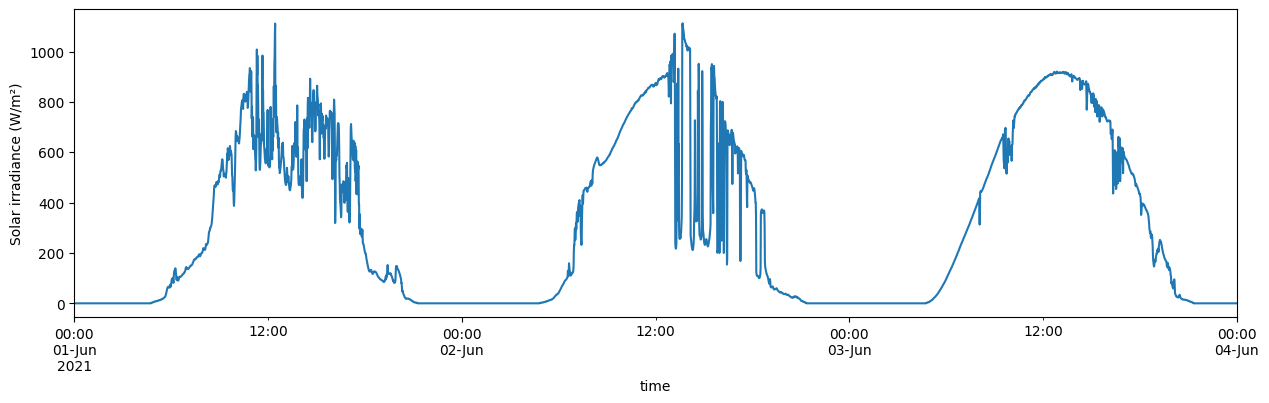

In [9]:
# Plot solar irradiance
fig, ax = plt.subplots(figsize=(15,4))
weather_df["solar"].plot(ax=ax)
ax.set_ylabel("Solar irradiance (W/m²)")

### Task

We assume one time step in SimPy equals 1 second in reality.

- Create a process `solar_panel(env, battery, weather_df)` that charges the battery during the simulation following the weather CSV data
- The raw weather data is reporting solar irradiance in W/m² and wind speed in m/s. A simple formular to model the solar panel's power production is solar irradiance (W/m²) times the area of your solar panel (m²) times the efficiency of the solar pannel (usually around 18%)
- Take care of the time units: You can assume one timestep every minute, but the battery assumes watt-hours as a unit

In [10]:
def solar_panel(env, battery, solar_values):
    """TODO"""
    for solar in solar_values:
        battery.update(solar * SOLAR_AREA * SOLAR_EFFICIENCY / 60)
        yield env.timeout(60)

### Run Simulation and Visualize Results

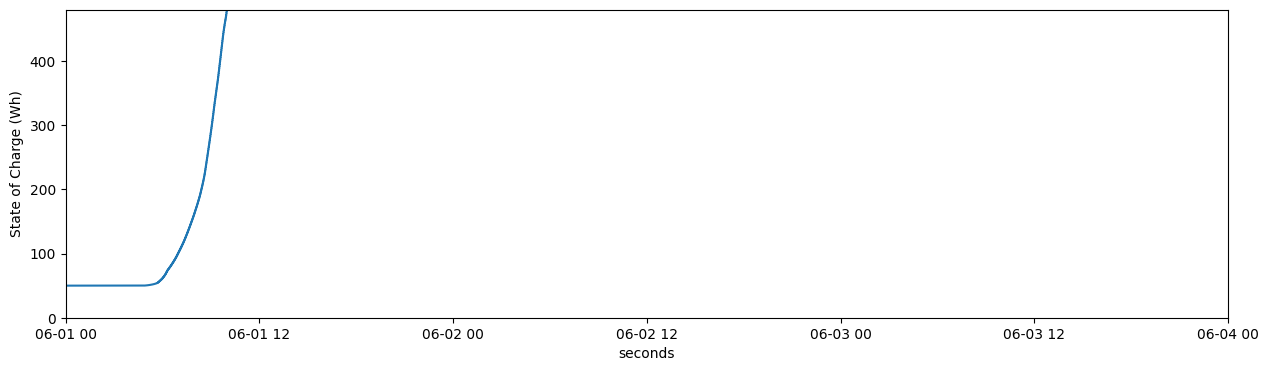

In [11]:
solar_values = weather_df["solar"].values

battery = Battery(capacity=BATTERY_CAPACITY, soc=BATTERY_INITIAL_SOC)
battery_socs = []

env = simpy.Environment()
env.process(solar_panel(env, battery, solar_values=solar_values))
env.process(read_battery(env, battery, battery_socs))
env.run(until=len(INDEX))

plot_battery_soc(battery_socs)

# Task 2: Modeling Tasks

`taxi_2021-06.csv` contains some taxi rides in NYC during June 2021. We are only interested in the `passenger_count` column and (for simplicity) assume that each taxi sends one offloading job to the 

one row per taxi ride, with information on the *pickup_date*, *dropoff_date*, *passenger_count*, and *trip_duration* in seconds.

In [12]:
with open("data/taxi_2021-06.csv", "r") as csvfile:
    tasks_df = pd.read_csv(csvfile, index_col=0)
task_arrival_times = [pd.to_datetime(dt) for dt in tasks_df.index]
task_arrival_times[:10]

[Timestamp('2021-06-01 00:00:13'),
 Timestamp('2021-06-01 00:01:01'),
 Timestamp('2021-06-01 00:01:13'),
 Timestamp('2021-06-01 00:02:49'),
 Timestamp('2021-06-01 00:03:27'),
 Timestamp('2021-06-01 00:06:05'),
 Timestamp('2021-06-01 00:07:52'),
 Timestamp('2021-06-01 00:09:02'),
 Timestamp('2021-06-01 00:09:05'),
 Timestamp('2021-06-01 00:09:36')]

### Task

- Create process that discharges 1 Wh from the battery for every incoming task
    - Help: Subtracting two [datetime](https://docs.python.org/3.8/library/datetime.html#datetime.datetime) objects results in a [timedelta](https://docs.python.org/3.8/library/datetime.html#datetime.timedelta) object. [timedelta.total_seconds()](https://docs.python.org/3.8/library/datetime.html#datetime.timedelta.total_seconds) returns the delta in seconds.
- Bonus: Besides modeling the execution, we also want to record how many tasks were completed successfully and how many tasks did not have enough energy. If there was enough energy to fully compute the task (i.e. the returned excess energy is 0), increment the "completed" property in the `task_stats` dictionary. If not, increment the "aborted" property.

In [13]:
def compute_tasks(env, battery, task_arrival_times, task_stats):
    last_task_time = START_DATE
    for now in task_arrival_times:
        """TODO"""
        seconds_since_last_task = (now - last_task_time).seconds
        yield env.timeout(seconds_since_last_task)
        excess = battery.update(-1)
        if excess >= 0:
            task_stats["completed"] += 1
        else:
            task_stats["aborted"] += 1
        last_task_time = pd.to_datetime(now)

### Run Simulation and Visualize Results

{'completed': 5243, 'aborted': 1179}


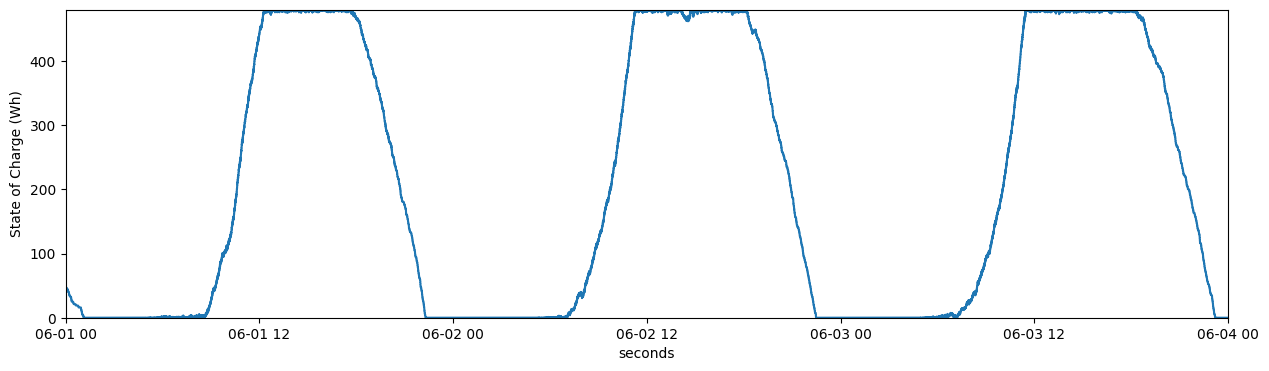

In [14]:
battery = Battery(capacity=BATTERY_CAPACITY, soc=BATTERY_INITIAL_SOC)
battery_socs = []
task_stats = dict(completed=0, aborted=0)

env = simpy.Environment()
env.process(solar_panel(env, battery, solar_values=solar_values))
env.process(compute_tasks(env, battery, task_arrival_times, task_stats))
env.process(read_battery(env, battery, battery_socs))
env.run(until=len(INDEX))

plot_battery_soc(battery_socs)
print(task_stats)

# Task 3: High Priority Tasks

Additionally to the taxi tasks, we now introduce a second type of workload. High priority tasks resemble critical infrastrucutre and must be computed by our edge infrastructure to ensure ...

This time you can get creative, explore different ways to manipulate the simulation and come up with new approaches. Ideas include:

- Play with the size of the battery, solar panel, etc.
- Reduce the amount of energy consumed by low-priority tasks by rejecting (some of) them upfront
- Try maintaining a certain state of charge at any time to ensure save
- ...

In [15]:
def high_priority_tasks(env, battery, task_stats):
    np.random.seed(0)
    while True:
        yield env.timeout(np.random.randint(3600 * 6))
        excess = battery.update(-50)
        if excess >= 0:
            print(f"{simtime_to_datetime(env.now)}: Yey")
        if excess < 0:
            print(f"{simtime_to_datetime(env.now)}: :(")

2021-06-01 00:45:32: :(
2021-06-01 03:45:31: :(
2021-06-01 06:29:36: :(
2021-06-01 11:57:04: Yey
2021-06-01 15:35:47: Yey
2021-06-01 21:29:50: Yey
2021-06-02 00:03:35: :(
2021-06-02 05:49:32: :(
2021-06-02 09:44:48: Yey
2021-06-02 13:53:43: Yey
2021-06-02 18:10:53: Yey
2021-06-02 22:34:45: :(
2021-06-03 00:27:09: :(
2021-06-03 05:58:01: :(
2021-06-03 10:02:11: Yey
2021-06-03 14:47:00: Yey
2021-06-03 20:03:23: Yey
2021-06-03 22:55:30: :(
{'completed': 5073, 'aborted': 1349}


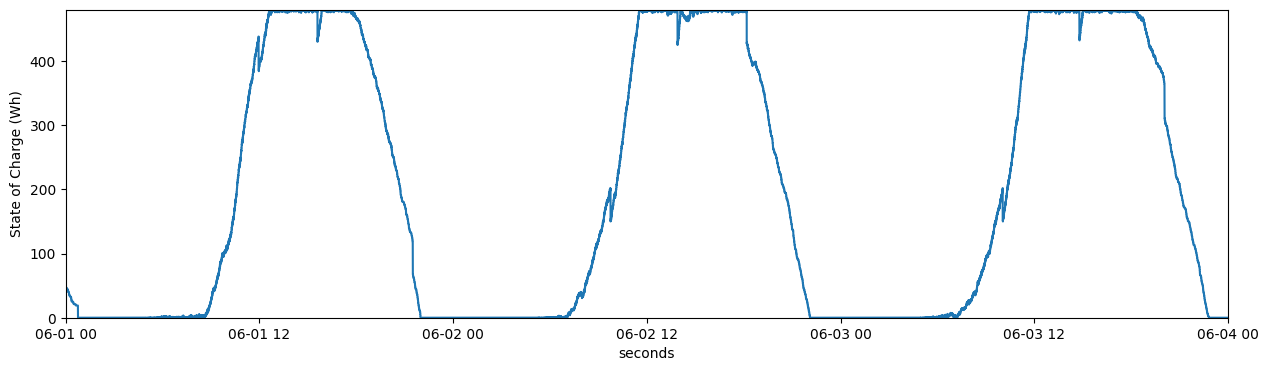

In [16]:
battery = Battery(capacity=BATTERY_CAPACITY, soc=BATTERY_INITIAL_SOC)
battery_socs = []
task_stats = dict(completed=0, aborted=0)

env = simpy.Environment()
env.process(solar_panel(env, battery, solar_values=solar_values))
env.process(compute_tasks(env, battery, task_arrival_times, task_stats))
env.process(high_priority_tasks(env, battery, task_stats))
env.process(read_battery(env, battery, battery_socs))
env.run(until=len(INDEX))

plot_battery_soc(battery_socs)
print(task_stats)